In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

import requests

import ddsl_load_tester as load_tester

# Testing Functionality

In [22]:
load_tester.get_current_stats()

{'current_response_time_percentile_50': None,
 'current_response_time_percentile_95': None,
 'errors': [],
 'fail_ratio': 0.0,
 'state': 'ready',
 'stats': [{'avg_content_length': 0,
   'avg_response_time': 0,
   'current_rps': 0.0,
   'max_response_time': 0,
   'median_response_time': 0,
   'method': None,
   'min_response_time': 0,
   'name': 'Total',
   'num_failures': 0,
   'num_requests': 0}],
 'total_rps': 0.0,
 'user_count': 0}

In [5]:
load_tester.set_target_user_count(50)

True

In [6]:
load_tester.reset_stats()

True

In [7]:
load_tester.stop_test()

True

In [43]:
load_tester.get_current_stats()

{'current_response_time_percentile_50': None,
 'current_response_time_percentile_95': None,
 'errors': [{'error': "HTTPError('502 Server Error: Bad Gateway for url: http://wg2.nmahmoudi.ir:31112/function/pyfibo/',)",
   'method': 'GET',
   'name': '/function/pyfibo/',
   'occurences': 11676}],
 'fail_ratio': 0.0,
 'state': 'stopped',
 'stats': [{'avg_content_length': 0,
   'avg_response_time': 0,
   'current_rps': 0.0,
   'max_response_time': 0,
   'median_response_time': 0,
   'method': 'GET',
   'min_response_time': 0,
   'name': '/function/pyfibo/',
   'num_failures': 0,
   'num_requests': 0},
  {'avg_content_length': 0,
   'avg_response_time': 0,
   'current_rps': 0.0,
   'max_response_time': 0,
   'median_response_time': 0,
   'method': None,
   'min_response_time': 0,
   'name': 'Total',
   'num_failures': 0,
   'num_requests': 0}],
 'total_rps': 0.0,
 'user_count': 0}

# Testing Object

In [74]:
lt = load_tester.DdslLoadTester(hatch_rate=100, temp_stat_max_len=5, base='http://localhost:8089/')
lt.change_count(50)

True

In [75]:
lt.start_capturing()

In [77]:
lt.get_all_stats()

{'time': [1556753351.3287334,
  1556753353.332906,
  1556753355.3335166,
  1556753357.3305836,
  1556753359.3368878],
 'current_response_time_percentile_50': [None, None, None, None, None],
 'current_response_time_percentile_95': [None, None, None, None, None],
 'fail_ratio': [0.0, 0.0, 0.0, 0.0, 0.0],
 'total_rps': [0.0, 0.0, 0.0, 0.0, 0.0],
 'user_count': [50, 50, 50, 50, 50],
 'avg_response_time': [0,
  53.74026298522949,
  40.00663757324219,
  40.00663757324219,
  0],
 'current_rps': [0.0, 0.0, 0.0, 0.0, 0.0],
 'max_response_time': [0,
  57.170867919921875,
  78.32837104797363,
  78.32837104797363,
  0],
 'median_response_time': [0,
  50.30965805053711,
  25.400876998901367,
  25.400876998901367,
  0],
 'min_response_time': [0,
  50.30965805053711,
  23.400068283081055,
  23.400068283081055,
  0],
 'num_failures': [0, 0, 0, 0, 0],
 'num_requests': [0, 2, 10, 10, 0]}

In [15]:
temp_stats = lt.get_temp_stats()
temp_stats

[{'current_response_time_percentile_50': 57.43908882141113,
  'current_response_time_percentile_95': 98.80471229553223,
  'errors': [],
  'fail_ratio': 0.0,
  'state': 'running',
  'stats': [{'avg_content_length': 4.0,
    'avg_response_time': 45.568084716796875,
    'current_rps': 0.0,
    'max_response_time': 98.80471229553223,
    'median_response_time': 28.05781364440918,
    'method': 'GET',
    'min_response_time': 24.00517463684082,
    'name': '/function/pyfibo/',
    'num_failures': 0,
    'num_requests': 15},
   {'avg_content_length': 4.0,
    'avg_response_time': 45.568084716796875,
    'current_rps': 0.0,
    'max_response_time': 98.80471229553223,
    'median_response_time': 28.05781364440918,
    'method': None,
    'min_response_time': 24.00517463684082,
    'name': 'Total',
    'num_failures': 0,
    'num_requests': 15}],
  'total_rps': 0.0,
  'user_count': 50,
  'time': 1556743350.3435028},
 {'current_response_time_percentile_50': 36.06247901916504,
  'current_response

In [16]:
load_tester.get_stats_arr(temp_stats, 'current_response_time_percentile_50')

[57.43908882141113,
 36.06247901916504,
 26.9467830657959,
 26.9467830657959,
 24.608612060546875]

In [17]:
load_tester.get_stats_arr_stats(temp_stats, 'avg_response_time')

[45.568084716796875,
 55.91193267277309,
 49.9715656042099,
 49.9715656042099,
 34.6970796585083]

In [73]:
lt.stop_test()

True

# Testing Sequence

In [86]:
import time

loop_timer = load_tester.TimerClass()
total_timer = load_tester.TimerClass()

user_sequence = [50,100,500,1000,1000,1000,500,100,50]
lt = load_tester.DdslLoadTester(hatch_rate=100, temp_stat_max_len=5, base='http://localhost:8089/')
lt.change_count(user_sequence[0])
lt.start_capturing()

loop_timer.tic()
total_timer.tic()

from tqdm.auto import tqdm
tqdm.pandas()

results = []
for i in tqdm(range(len(user_sequence))):
    user_count = user_sequence[i]
    lt.change_count(user_count)
    
    time.sleep(10 - loop_timer.toc())
    
    loop_timer.tic()
    
    result = lt.get_all_stats()
    
#     temp_stats = lt.get_temp_stats()
#     result = {}
#     result['avg_response_time'] = np.mean(np.array(load_tester.get_stats_arr_stats(temp_stats, 'avg_response_time')))
#     result['max_response_time'] = np.max(np.array(load_tester.get_stats_arr_stats(temp_stats, 'max_response_time')))
#     result['min_response_time'] = np.min(np.array(load_tester.get_stats_arr_stats(temp_stats, 'min_response_time')))
#     result['fail_ratio'] = np.mean(np.array(load_tester.get_stats_arr(temp_stats, 'fail_ratio')))
#     result['user_count'] = user_count
#     result['time'] = total_timer.toc() / 60
    results.append(result)
    
lt.stop_test()

True

In [87]:
import pandas as pd

res = pd.DataFrame(data=results)
res

,avg_response_time,current_response_time_percentile_50,current_response_time_percentile_95,current_rps,fail_ratio,max_response_time,median_response_time,min_response_time,num_failures,num_requests,time,total_rps,user_count
0,"[0, 0, 0, 27.95189619064331]","[None, None, None, None]","[None, None, None, None]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 31.142711639404297]","[0, 0, 0, 26.289701461791992]","[0, 0, 0, 25.658607482910156]","[0, 0, 0, 0]","[0, 0, 0, 4]","[1556753737.804115, 1556753739.8076336, 155675...","[0.0, 0.0, 0.0, 0.0]","[50, 50, 50, 50]"
1,"[32.35304355621338, 65.47905007998149, 40.5230...","[None, None, None, None, None]","[None, None, None, None, None]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[52.57391929626465, 127.26426124572754, 88.710...","[24.979114532470703, 78.21822166442871, 29.368...","[24.62005615234375, 36.65590286254883, 24.3837...","[0, 0, 0, 0, 0]","[4, 24, 5, 4, 8]","[1556753745.821853, 1556753747.8152251, 155675...","[0.0, 0.0, 0.0, 0.0, 0.0]","[50, 100, 100, 100, 100]"
2,"[40.890018145243324, 45.55032803462102, 0]","[None, None, None]","[None, None, None]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[70.46389579772949, 69.39387321472168, 0]","[27.46868133544922, 44.725656509399414, 0]","[24.747610092163086, 23.775100708007812, 0]","[0, 0, 0]","[6, 13, 0]","[1556753755.8301723, 1556753761.8303337, 15567...","[0.0, 0.0, 0.0]","[100, 500, 500]"
3,"[0, 280.30375639597577, 69.92030143737793]","[None, None, None]","[None, None, None]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0, 347.8202819824219, 115.41104316711426]","[0, 260, 70.41049003601074]","[0, 239.24684524536133, 25.096893310546875]","[0, 0, 0]","[0, 6, 9]","[1556753765.8445244, 1556753771.8472726, 15567...","[0.0, 0.0, 0.0]","[500, 1000, 1000]"
4,"[69.92030143737793, 87.86227152897762, 95.8531...","[None, None, None, None, None]","[None, None, None, None, None]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[115.41104316711426, 180.8309555053711, 233.41...","[70.41049003601074, 78.39202880859375, 80.3282...","[25.096893310546875, 25.673389434814453, 22.68...","[0, 0, 0, 0, 0]","[9, 52, 99, 94, 96]","[1556753775.844755, 1556753777.8546805, 155675...","[0.0, 0.0, 0.0, 0.0, 0.0]","[1000, 1000, 1000, 1000, 1000]"
5,"[97.35682275560167, 114.27308582678074, 168.77...","[None, None, None, None, None]","[None, None, None, None, None]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[222.60475158691406, 317.1060085296631, 310.47...","[76.5383243560791, 95.83449363708496, 170, 73....","[23.52428436279297, 22.116661071777344, 65.917...","[0, 0, 0, 0, 0]","[81, 82, 32, 35, 34]","[1556753785.866472, 1556753787.863009, 1556753...","[0.0, 0.0, 0.0, 0.0, 0.0]","[1000, 1000, 1000, 1000, 1000]"
6,"[0, 0, 0, 0, 69.64445114135742]","[None, None, None, None, None]","[None, None, None, None, None]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 69.64445114135742]","[0, 0, 0, 0, 69.64445114135742]","[0, 0, 0, 0, 69.64445114135742]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]","[1556753795.885185, 1556753797.8772962, 155675...","[0.0, 0.0, 0.0, 0.0, 0.0]","[1000, 500, 500, 500, 500]"
7,"[68.07851791381836, 0, 0, 69.10467147827148, 0]","[None, None, None, None, None]","[None, None, None, None, None]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[68.07851791381836, 0, 0, 69.10467147827148, 0]","[68.07851791381836, 0, 0, 69.10467147827148, 0]","[68.07851791381836, 0, 0, 69.10467147827148, 0]","[0, 0, 0, 0, 0]","[1, 0, 0, 1, 0]","[1556753805.88187, 1556753807.8862, 1556753809...","[0.0, 0.0, 0.0, 0.0, 0.0]","[500, 100, 100, 100, 100]"
8,"[0, 27.336835861206055, 34.53735510508219, 40....","[None, None, None, None, None]","[None, None, None, None, None]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0, 28.98240089416504, 67.53993034362793, 82.1...","[0, 25.69127082824707, 25.87747573852539, 26.7...","[0, 25.69127082824707, 24.270296096801758, 25....","[0, 0, 0, 0, 0]","[0, 2, 6, 4, 8]","[1

In [92]:
r = pd.DataFrame(data=result)
r.to_dict()

{'time': {0: 1556753815.8902915,
  1: 1556753817.8965285,
  2: 1556753819.8942451,
  3: 1556753821.8993683,
  4: 1556753823.900712},
 'current_response_time_percentile_50': {0: None,
  1: None,
  2: None,
  3: None,
  4: None},
 'current_response_time_percentile_95': {0: None,
  1: None,
  2: None,
  3: None,
  4: None},
 'fail_ratio': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0},
 'total_rps': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0},
 'user_count': {0: 100, 1: 50, 2: 50, 3: 50, 4: 50},
 'avg_response_time': {0: 0.0,
  1: 27.336835861206055,
  2: 34.53735510508219,
  3: 40.860772132873535,
  4: 30.777275562286377},
 'current_rps': {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0},
 'max_response_time': {0: 0.0,
  1: 28.98240089416504,
  2: 67.53993034362793,
  3: 82.17024803161621,
  4: 67.12937355041504},
 'median_response_time': {0: 0.0,
  1: 25.69127082824707,
  2: 25.87747573852539,
  3: 26.76868438720703,
  4: 25.44260025024414},
 'min_response_time': {0: 0.0,
  1: 25.69127082824707,
  2: 24.

ValueError: setting an array element with a sequence.

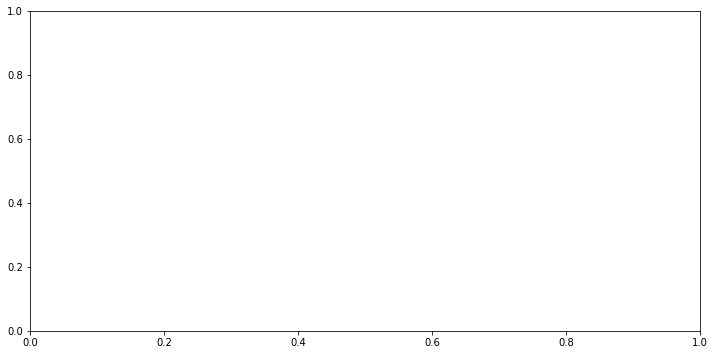

In [85]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12,20))
plt.subplot(311)
plt.plot(res['time'], res['avg_response_time'], label='avg_response_time')
plt.plot(res['time'], res['max_response_time'], label='max_response_time')
plt.plot(res['time'], res['min_response_time'], label='min_response_time')
plt.xlabel('Time (minutes)')
plt.ylabel('Average Response Time (ms)')
plt.legend()

plt.subplot(312)
plt.plot(res['time'], res['user_count'])
plt.xlabel('Time (minutes)')
plt.ylabel('Num of Users')

plt.subplot(313)
plt.plot(res['time'], res['fail_ratio'])
plt.xlabel('Time (minutes)')
plt.ylabel('Fail Ratio')